## Processamento de linguagem natural com python
Base de dados sobre a parte textual de currículos com palavras-chave "cientista de dados".

Os currículos foram classificados em duas classes, sendo que aqueles "sinalizados" foram convidados à entrevista.

Dados retirados do kaggle através do link :https://www.kaggle.com/samdeeplearning/deepnlp?select=Sheet_2.csv

Objetivo: treinar um modelo que possa classificar os currículos em "aprovados" ou não para a entrevista, com base nos textos do dataset.

#### Importação das bibliotecas

In [1]:
import pandas as pd #processamento de dados
pd.set_option('display.max_rows', 130)
import numpy as np #arrays e matrizes
import matplotlib.pyplot as plt #gráficos
import seaborn as sns

import re   #limpeza de símbolos
import nltk #processamento de linguagem natural
nltk.download('stopwords') 
from nltk.corpus import stopwords as sw #palavras irrelevantes
stopwords = sw.words('english') 
from nltk.stem.porter import PorterStemmer #raiz da palavra

from sklearn.feature_extraction.text import CountVectorizer #contagem de palavras
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score

from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Importação dos dados e pré-processamento

In [2]:
dados = pd.read_csv('database.csv', encoding='latin-1').set_index('resume_id')
dados['resume_text'].replace('\r', '', regex=True, inplace=True)
dados['resume_text'] = dados['resume_text'].str.strip()
print('Quantidade de observações: {} \nEstrutura do conjunto de dados: '.format(dados.shape[0]))
dados.sample(3)

Quantidade de observações: 125 
Estrutura do conjunto de dados: 


,class,resume_text
resume_id,,
resume_32,flagged,Eric Anderson Data ScientistBrattleboro VT - E...
resume_105,flagged,Steven BradyPostdoctoral Fellow - VT Cooperati...
resume_27,not_flagged,Denis ChasseÕReading Specialist and Professio...


#### Processamento do texto

In [3]:
corpo_texto = []
stemmer = PorterStemmer()
for i in np.arange(0, 125):
    #Removendo símbolos que não são letras
    texto_revisado = re.sub('[^a-zA-Z]', ' ', dados['resume_text'][i])
    texto_revisado = texto_revisado.lower()
    texto_revisado = texto_revisado.strip()
    texto_revisado = texto_revisado.split()
    #Trazendo a palavra para a forma raiz
    texto_final = []
    for x in texto_revisado:
        texto_final.append(stemmer.stem(x))
    #Removendo palavras irrelevantes  
    for x in texto_final:
        if x in stopwords:
            texto_final.remove(x)
    texto_final = ' '.join(texto_final)
    corpo_texto.append(texto_final)

#### Definição de variáveis preditoras e variável alvo

In [4]:
# Criando uma matriz em que cada linha contém todas as palavras disponíveis no corpo do texto
# se determinada palavra está contida na frase da primeira linha, por exemplo, então recebemos o 1
# se não 0

cv = CountVectorizer()
x = cv.fit_transform(corpo_texto).toarray()
print('Exemplo: primeiro currículo: {}'.format(x[0]))

# definindo a variável target
y = np.array(pd.get_dummies(data=dados, columns=['class'])['class_flagged'])
print('Exemplo: variável y para o primeiro currículo: {}'.format(y[0]))

Exemplo: primeiro currículo: [0 0 0 ... 0 0 0]
Exemplo: variável y para o primeiro currículo: 0


#### Divisão entre dados de treino e teste

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.45)

#### Esolha do modelo de classificação

In [6]:
# Aplicação da validação cruzada para comparar o modelo de Naive Bayes com Logística Linear
model_1 = MultinomialNB()
model_2 = LogisticRegression()
kfold = KFold()

resultado_1 = cross_val_score(model_1, x_train, y_train, cv=kfold)
print('Acurácia média por Naive Bayes: {}'.format(round(resultado_1.mean(), 4)))

resultado_2 = cross_val_score(model_2, x_train, y_train, cv=kfold)
print('Acurácia média por Logística Binária: {}'.format(round(resultado_2.mean(),4)))

if resultado_2.mean() > resultado_1.mean():
    print('Maior acurácia por logística binária, logo será o modelo escolhido nesse cenário')
else:
    print(('Maior acurácia por Naive Bayes, logo será o modelo escolhido nesse cenário'))

Acurácia média por Naive Bayes: 0.7516
Acurácia média por Logística Binária: 0.822
Maior acurácia por logística binária, logo será o modelo escolhido nesse cenário


#### Treinamento do modelo

In [7]:
#Treinamento do modelo com 50% dos dados
model_2.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### Avaliação do modelo

In [8]:
#classe prevista para o conjunto de teste
y_predict = model_2.predict(x_test)
y_predict

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], dtype=uint8)

In [9]:
#probabilidade de ser evento do conjunto de teste
y_predict_proba = model_2.predict_proba(x_test)[:, 1]
y_predict_proba

array([7.14907359e-02, 2.69387490e-01, 3.79425852e-05, 8.12689023e-02,
       9.97765389e-01, 1.08811151e-05, 2.27236331e-01, 3.90601786e-01,
       3.83756548e-02, 7.14028615e-02, 1.38534802e-02, 3.66444210e-02,
       7.25333684e-01, 2.28803982e-02, 2.17733966e-01, 1.10441715e-02,
       7.06227615e-01, 7.81413561e-06, 5.21164493e-02, 5.23562031e-02,
       1.50183732e-01, 7.25209828e-04, 2.56723064e-02, 8.73432012e-02,
       1.42074761e-01, 9.62454373e-03, 6.04603717e-02, 2.49883811e-01,
       1.64581177e-03, 3.72855086e-03, 6.72887389e-01, 8.01106975e-03,
       6.13403257e-03, 6.00868697e-01, 3.86352162e-02, 2.77004166e-02,
       3.74394307e-01, 4.45722747e-02, 4.10577045e-01, 5.67887746e-02,
       2.62853424e-02, 2.30779507e-01, 8.06407275e-01, 6.54697476e-02,
       8.73139536e-03, 2.23967675e-05, 1.68804001e-01, 8.61713349e-03,
       1.69669449e-01, 4.01583006e-03, 2.84985943e-01, 2.70382184e-01,
       5.03540077e-02, 1.53419353e-03, 2.52205035e-05, 6.60336538e-01,
      

Confusion Matrix: 

[[38 11]
 [ 2  6]]

True positive: 6
True negative: 38
False positive: 2
False negative: 11

Accuracy: 0.77
Sensitivity: 0.35
Specificity: 0.95
Area under the ROC curve: 0.65
GINI coefficient: 0.3
ROC Curve:



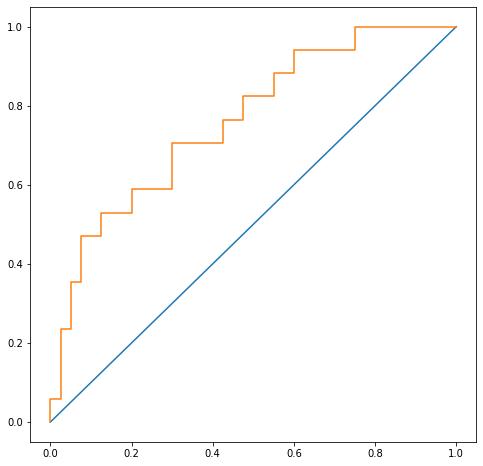

In [16]:
#visualização dos valores da matriz de confusao
tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
print('Confusion Matrix: \n')
print(confusion_matrix(y_test, y_predict).T)
print('\nTrue positive: {}'.format(tp))
print('True negative: {}'.format(tn))
print('False positive: {}'.format(fp))
print('False negative: {}'.format(fn))
print('\nAccuracy: {}'.format(round((tn+tp)/len(y_test), 2)))
print('Sensitivity: {}'.format(round(tp/(tp+fn), 2)))
print('Specificity: {}'.format(round(tn/(tn+fp), 2)))
print('Area under the ROC curve: {}'.format(round(roc_auc_score(y_test, y_predict), 2)))
print('GINI coefficient: {}'.format(round((roc_auc_score(y_test, y_predict)*2)-1, 2)))
print('ROC Curve:\n')

fpr, tpr, cutoff = roc_curve(y_test, y_predict_proba)
plt.figure(figsize=[8, 8])
sns.lineplot(x = [0, 1], y = [0,1])
plt.plot(fpr, tpr)
plt.savefig('roc.jpeg')
plt.show()

#### Compartilhamento dos dados

In [11]:
# Caso existisse um segundo dataset
# é possível acrescentar a classe prevista e a probabilidade da classe
# vamos fazer isso para o próprio conjunto de dados utilizado como treinamento
# porém deixamos explícito que isso pode cair em overfitting e
# não faz sentido utilizar os mesmos dados de treino para predição.
dados['class'] = y
dados['predict_class'] = model_2.predict(x)
dados['predict_class_1_prob'] = np.array(round(pd.DataFrame(model_2.predict_proba(x))[1], 4))

# visualizando a estrutura final do dataset
# contendo a probabilidade do currículo ser sinalizado para entrevista
dados.sample(10)

,class,resume_text,predict_class,predict_class_1_prob
resume_id,,,,
resume_59,0,Karl JohnsonProvide counsel - PRIVATE CONSULTI...,0,0.0000
resume_85,0,Nawras Abureehan Growth & Data ScientistMiddle...,1,0.6729
resume_75,0,Meghan LoutEcologist/Project Manager - Western...,0,0.4106
resume_86,0,Nicholas SindorfFounding Father - Sigma Phi Ep...,0,0.1688
resume_41,0,George Slusser Advisory EngineerMilton VT - Em...,0,0.0139
resume_47,0,Howard Alford Laboratory Assistant InternMc In...,0,0.0080
resume_65,0,Louis LarosiliereSenior Director Aero & Hydrod...,0,0.2499
resume_115,1,Ph.D.South Royalton VT - Email me on Indeed: i...,1,0.9928
resume_125,0,Research and Development Scientist - Burlingto...,0,0.0074


#### Nuvem de palavras
Utilizando as classificações reais do dataset é possível construir uma nuvem de palavras com cada classe (sinalizada x não sinalizada) com o objetivo de verificar as palavras mais recorrentes em cada classe de currículos

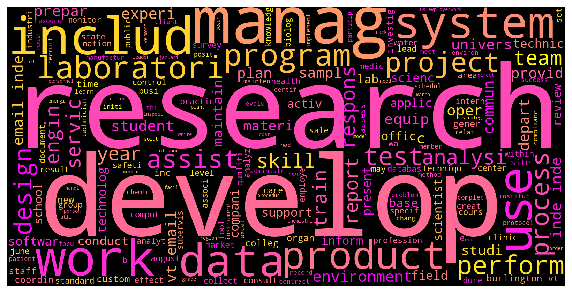

In [14]:
#classe 0
corpo_texto = []
wordcd = []
stemmer = PorterStemmer()
for i in np.arange(0, 92):
    #Removendo símbolos que não são letras
    texto_revisado = re.sub('[^a-zA-Z]', ' ', dados[dados['class'] == 0]['resume_text'][i])
    texto_revisado = texto_revisado.lower()
    texto_revisado = texto_revisado.strip()
    texto_revisado = texto_revisado.split()
    #Trazendo a palavra para a forma raiz
    texto_final = []
    for x in texto_revisado:
        texto_final.append(stemmer.stem(x))
    #Removendo palavras irrelevantes  
    for x in texto_final:
        if x in stopwords:
            texto_final.remove(x)
        else:
            wordcd.append(x)

# gerar uma wordcloud
wordcloud = WordCloud(background_color="black",width=1600, height=800, colormap='spring').generate(' '.join(wordcd))

# mostrar a imagem final
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()

plt.imshow(wordcloud)
plt.show()
wordcloud.to_file("wordcloud_0.png")

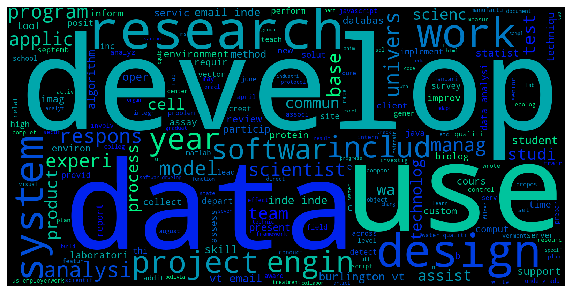

In [15]:
# classe 1
wordcd = []
stemmer = PorterStemmer()
for i in np.arange(0, 33):
    #Removendo símbolos que não são letras
    texto_revisado = re.sub('[^a-zA-Z]', ' ', dados[dados['class'] == 1]['resume_text'][i])
    texto_revisado = texto_revisado.lower()
    texto_revisado = texto_revisado.strip()
    texto_revisado = texto_revisado.split()
    #Trazendo a palavra para a forma raiz
    texto_final = []
    for x in texto_revisado:
        texto_final.append(stemmer.stem(x))
    #Removendo palavras irrelevantes  
    for x in texto_final:
        if x in stopwords:
            texto_final.remove(x)
        else:
            wordcd.append(x)

# gerar uma wordcloud
wordcloud = WordCloud(background_color="black",
                      width=1600, height=800,
                      colormap='winter').generate(' '.join(wordcd))

# mostrar a imagem final
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()

plt.imshow(wordcloud)
plt.show()
wordcloud.to_file("wordcloud_1.png")